# NGRE and GRE data

### Authors:
Anna Igolkina

## Libraries & Paths

In [30]:
library(readxl)
library(ggplot2)
library(gridExtra)
library(grid)
options(repr.plot.width=10, repr.plot.height=7)

path_ngre_human = '../human/ngre/'
path_gre_human = '../human/gre/'
path_ngre_mouse = '../mouse/ngre/'
path_gre_mouse = '../mouse/gre/'

path_results = '../results/'



path_human = '../human/'
path_mouse = '../mouse/'

path_gene_annot = '../gene_annotation/'

target_stats = c('gre', 'ngre')

# Our tags only
target_tags = c('H3K4me3', 'H3K27me3')

# One additional tag for heterochromatin
target_tags = c('H3K4me3', 'H3K27me3', 'H3K9me3')

# With additional tags from Dasha: H3K9ac и H3K27ac 
target_tags = c('H3K4me3', 'H3K9ac', 'H3K27ac', 'H3K27me3', 'H3K9me3') 

## Read NGRE and GRE data for Human

In [32]:
stat_all_h = c()  # Table to accumulate all statistics
for(stat in target_stats)  # GRE or NGRE
{
    path_stat = paste0(c(path_human, stat, '/'), collapse = '')
    files = list.files(path_stat)
    
    for(tag in target_tags) 
    {   
        acc_stat = 0  # Accumulate GRE or NGRE, the mean across all cell lines
        for(file in files)
        {
            filename = paste0(path_stat, file)

            data = as.data.frame(read_excel(filename, sheet = tag))
            gene_names = data[,'Gene_name']
            acc_stat = acc_stat + data[,'total_signal']
        }
        acc_stat = acc_stat / length(files)
        length(gene_names)
        length(acc_stat)
        names(acc_stat) <- gene_names
        
        file_acc_stat = paste0(c(path_results, 'human_', stat, '_', tag, '.txt'), collapse = '')

        write.table(file = file_acc_stat, x = acc_stat, quote = FALSE, col.names = FALSE)
        
        # Accumulate all statistics
        stat_all_h = cbind(stat_all_h, acc_stat)
        colnames(stat_all_h)[ncol(stat_all_h)] <- paste0(c(stat, tag), collapse = '_')
    }  
}
head(stat_all_h)

In [33]:
# Save backgrounf info for DAVID annotation
write.table(paste0(path_gene_annot, 'background_genes_human.txt'), 
            x=gene_names, quote = FALSE, row.names = FALSE, col.names = FALSE)

## Read NGRE and GRE data for Mouse

In [34]:
stat_all_m = c() 
for(tag in target_tags)
{
    for(stat in target_stats)  # GRE or NGRE
    {
        path_stat = paste0(c(path_mouse, stat, '/'), collapse = '')
        files = list.files(path_stat, pattern = paste0(c('*', tag, '.txt'), collapse=""))
        
        acc_stat = 0  # Accumulate GRE or NGRE, the mean across all cell lines
        for(file in files)
        {
            filename = paste0(path_stat, file)

            data = as.data.frame(read.table(filename,header  = TRUE))
            gene_names = data[,'gene']
            acc_stat = acc_stat + data[,'total_signal']
        }
        acc_stat = acc_stat/length(files)
        length(gene_names)
        length(acc_stat)
        names(acc_stat) <- gene_names

        file_acc_stat = paste0(c(path_results, 'mouse_', stat, '_', tag, '.txt'), collapse = '')

        write.table(file = file_acc_stat, x = acc_stat, quote = FALSE, col.names = FALSE)
        
        # Accumulate all statistics
        stat_all_m = cbind(stat_all_m, acc_stat)
        colnames(stat_all_m)[ncol(stat_all_m)] <- paste0(c(stat, tag), collapse = '_')
    }  
}
head(stat_all_m)

,gre_H3K4me3,ngre_H3K4me3,gre_H3K27me3,ngre_H3K27me3,gre_H3K9me3,ngre_H3K9me3,gre_H3K9ac,ngre_H3K9ac,gre_H3K27ac,ngre_H3K27ac
A1BG,1.8815,3.4985,1.5385,2.7360,3.2475,3.3545,1.1985,2.5225,1.4185,2.1895
A1CF,7.1685,1.4625,9.2570,11.1680,5.4070,15.6625,4.6330,1.1725,2.5645,0.3945
A2M,3.6080,1.2010,10.4165,9.2320,4.7900,7.2950,0.8265,0.1685,3.1560,2.8870
A3GALT2,6.9180,4.1780,4.3605,1.9995,9.9540,13.0280,4.3515,1.9940,5.2305,6.4895
A4GALT,7.3540,12.6315,16.8380,21.8400,6.3170,8.2100,6.5175,12.2420,10.7980,15.5810
A4GNT,5.4130,9.8470,11.5800,27.8885,5.2515,4.8880,3.0535,8.6010,2.7190,5.5515


In [35]:
# Save backgrounf info for DAVID annotation
write.table(paste0(path_gene_annot, 'background_genes_mouse.txt'), 
            x=gene_names, quote = FALSE, row.names = FALSE, col.names = FALSE)

## Create Plots for "GRE vs NGRE" for Human & Mouse

In [37]:
stats = list(Human = stat_all_h, Mouse = stat_all_m)
names(stats)


[1] "Human" "Mouse"

In [47]:
plot_list = list()
for(istat in 1:length(stats))
{
    stat_all = stats[[istat]]
    for(tag in target_tags) 
    {
        # Get profiles
        gre = stat_all[,paste0('gre_', tag)]
        ngre = stat_all[,paste0('ngre_', tag)]

        # Fit Linear Regressio with zero intercept
        slope = coef(lm(ngre ~ gre - 1))

        # Find outliers
        cutoff = 0.95
        point_dist = abs(-slope * gre + ngre) / slope
        idx_dist_up = ngre > slope * gre
        idx_dist_down = ngre < slope * gre

        point_dist_up = point_dist[idx_dist_up]
        point_dist_down = point_dist[idx_dist_down]

        threshold_up = quantile(point_dist_up, cutoff)
        threshold_down = quantile(point_dist_down, cutoff)


        outliers_up = idx_dist_up & (point_dist > threshold_up)
        outliers_down = idx_dist_down & (point_dist > threshold_down)
        normal_points = !outliers_up & !outliers_down

        # Calculate correlation and p-value and create annotation
        res = cor.test(gre, ngre)[c(3,4)]
        res_pval = as.character(round(res[[1]],2))
        res_cor = as.character(round(res[[2]],2))
        text_cor = paste('cor: ', res_cor)
        text_pval = paste('p-value: ', res_pval)
        annotations <- data.frame(xpos = Inf, ypos =  Inf,
                                  annotateText = paste0(c(text_cor, text_pval), collapse = '\n'),
                                  hjustvar = c(1), vjustvar = c(1)) #<- adjust


        # Create plot
        p <- ggplot(as.data.frame(cbind(gre, ngre)), aes(gre, ngre)) + 
             geom_point(alpha=0.1, color = 2*outliers_up + 3*outliers_down + normal_points)+ 
             geom_abline(intercept = 0, slope = slope, colour = '#858585') +
             geom_text(data=annotations,aes(x=xpos,y=ypos,hjust=hjustvar,vjust=vjustvar,label=annotateText))+
             ggtitle(paste0(c(names(stats)[istat], tag), collapse = ' ')) + labs(x='GRE', y='NGRE')
        plot_list[[length(plot_list) + 1]] = p
        
        # Save genes for the further DAVID annotation
        file_up = paste0(c(path_gene_annot, tolower(names(stats)[istat]), '_', tag, '_up.txt'), collapse = '')
        file_down = paste0(c(path_gene_annot, tolower(names(stats)[istat]), '_', tag, '_down.txt'), collapse = '')
        
        gene_names = rownames(stat_all)
        
        write.table(file = file_up, x = gene_names[outliers_up], 
                    quote = FALSE, col.names = FALSE, row.names = FALSE)
        write.table(file = file_down, x = gene_names[outliers_down], 
                    quote = FALSE, col.names = FALSE, row.names = FALSE)
    }
}

### Plotting

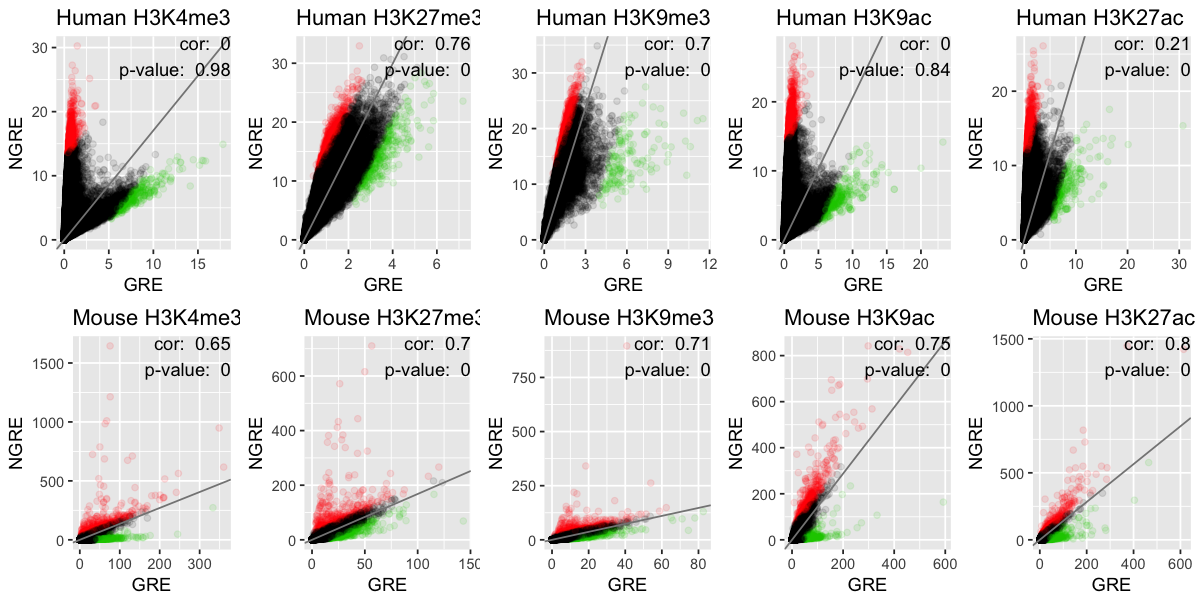

In [48]:
options(repr.plot.width=10, repr.plot.height=5)

n <- length(plot_list)
nCol <- length(target_tags)
do.call("grid.arrange", c(plot_list, ncol=nCol))